In [1]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
class OptimalRF():
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame, nest: int, maxd: int) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
    
    def find_best_rf(self):
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self):
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self):
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self):
        accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        precision = precision_score(self.y_test['class'], self.y_pred)
        recall = recall_score(self.y_test['class'], self.y_pred)
        f1 = 2*precision*recall/(precision + recall)
        
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1:", f1)
    
    def print_confusion_matrix(self):
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self):
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [24]:
front_dir = '../../data/intermediates/pca/cond1_pat1to81_outrmv_kfold-5'
fold = 4
X_train = np.loadtxt(front_dir + '/X_train-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test-' + str(fold) + '_cond1_pat1to81_outrmv_kfold-5.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

---- X_train ----
[[-1.82742212e+01 -3.98145812e+00  6.55245583e+01 ...  1.01044634e+01
   1.17347527e+01  3.93401596e-14]
 [-4.17912284e+00  4.78992728e+01 -3.55773650e+01 ...  1.77222392e-01
  -7.25702369e-01  3.93401596e-14]
 [ 5.20612126e+01  3.02950444e+01 -8.24141412e+01 ...  3.48514851e+00
   1.25295835e+00  3.93401596e-14]
 ...
 [ 4.80644696e+01 -2.75452573e+01  2.72246303e+01 ... -6.70882455e+00
   1.68857607e+00  3.93401596e-14]
 [-7.32522482e+01 -1.74808601e+01 -4.77703319e+00 ...  2.45125679e+00
  -4.26145323e+01  3.93401596e-14]
 [-4.16007016e+01 -5.75915927e+00  5.62736898e+00 ...  2.56782290e+00
   1.66648327e+00  3.93401596e-14]] 

---- X_test ----
[[-6.49192644e+01 -1.26846666e+01 -4.14178418e+01  1.94763593e+01
   1.22624392e+01 -1.36426419e+01 -1.41976185e+00  2.72988548e+00
   2.79020078e+00 -5.55657196e+00 -3.89841159e+00  3.98589894e+00
   4.38009701e+00  8.80413663e+00 -1.24915261e+01  1.48518102e+00
   1.30620912e+00 -3.83713465e+00  8.66918182e+00 -5.77731584e+

,subject,class
0,1,0
1,3,0
2,4,0
3,6,0
4,7,0
...,...,...
56,77,1
57,78,1
58,79,1
59,80,1


---- y_test ----


,subject,class
0,2,0
1,20,0
2,22,0
3,23,0
4,25,1
5,26,1
6,28,1
7,35,1
8,40,1
9,41,1


Best hyperparameters: {'max_depth': 27, 'n_estimators': 718}
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 1.0
F1: 0.8
CPU times: user 36.3 s, sys: 238 ms, total: 36.5 s
Wall time: 36.7 s


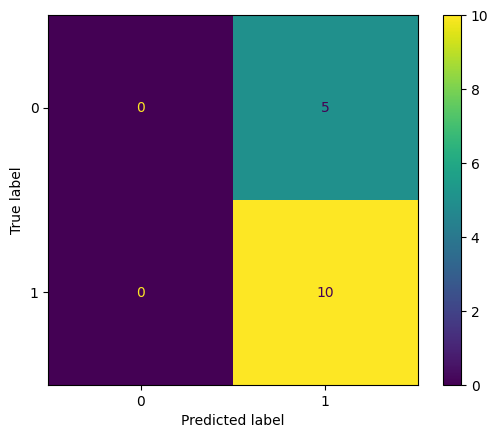

In [27]:
%%time
orf = OptimalRF(X_train, X_test, y_train, y_test, 1000, 40)
orf.run()